# Introduction

## Goals

- Find key drivers for Telco Churn
- Walkthrough the construction of a ML classfication Model
- Provide key points, explanations, and takeaways throughout the process.

In [69]:
#Standard
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('figure', figsize=(11, 9))
plt.rc('font', size=13)

# Preparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Modeling and Evalutation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix

# Testing
import scipy.stats as stats

# turn off warnings
import warnings
warnings.filterwarnings("ignore")

# Acquire & Prepare
from acquire import get_telco_data
#from prepare import telco_split

# Acquistion

In [30]:
# assigns the telco data as a Dataframe to a variable
telco = get_telco_data()
telco.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,DSL,Mailed check
1,4,1,1,0013-MHZWF,Female,0,No,Yes,9,Yes,...,Yes,Yes,Yes,Yes,69.4,571.45,No,Month-to-month,DSL,Credit card (automatic)
2,1,1,1,0015-UOCOJ,Female,1,No,No,7,Yes,...,No,No,No,Yes,48.2,340.35,No,Month-to-month,DSL,Electronic check
3,1,1,1,0023-HGHWL,Male,1,No,No,1,No,...,No,No,No,Yes,25.1,25.1,Yes,Month-to-month,DSL,Electronic check
4,3,1,1,0032-PGELS,Female,0,Yes,Yes,1,No,...,No,No,No,No,30.5,30.5,Yes,Month-to-month,DSL,Bank transfer (automatic)


In [31]:
#summarize data
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

In [32]:
#change total_charges column to float type
telco.total_charges = telco.total_charges.replace(' ', np.nan)
telco.total_charges = telco.total_charges.astype('float')

In [33]:
# assuming these are new customers who haven't paid/churned yet
# I will drop these observations as they only represent 0.16 % of the data, NBD
telco = telco.dropna()
len(telco)

7032

In [34]:
#statistical info for numeric variables
telco[['tenure', 'monthly_charges', 'total_charges']].describe()

,tenure,monthly_charges,total_charges
count,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441
std,24.545260,30.085974,2266.771362
min,1.000000,18.250000,18.800000
25%,9.000000,35.587500,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.862500,3794.737500
max,72.000000,118.750000,8684.800000


In [35]:
#plot distributions of indivdual variables


# Preparation

In [36]:
# looking at columns that were hidden
telco[['multiple_lines', 'online_security', 'online_backup', 'device_protection']]

,multiple_lines,online_security,online_backup,device_protection
0,Yes,No,No,No
1,No,No,No,No
2,No,Yes,No,No
3,No phone service,No,No,No
4,No phone service,Yes,No,No
...,...,...,...,...
7038,No,No internet service,No internet service,No internet service
7039,Yes,No internet service,No internet service,No internet service
7040,Yes,No internet service,No internet service,No internet service
7041,No,No internet service,No internet service,No internet service


In [37]:
### FIX THIS LATER
#create service_type column: phone, internet, phone & internet
#service_type = {
#((telco.phone_service == 'Yes') & (telco.internet_service_type == 'None')): 'phone only',
#((telco.phone_service == 'No') & (telco.internet_service_type != 'None')): 'internet only',
#((telco.phone_service == 'Yes') & (telco.internet_service_type != 'None')): 'phone & internet'
#}
#encode churn
telco['churned'] = telco.churn.map({'No': 0, 'Yes': 1})

#service_type

In [38]:
# Split on telco data, stratifying churn
# Return train, validate, and test as Dataframe.
def telco_split(df):
    train_validate, test = train_test_split(telco, test_size=.2, 
                                        random_state=123, 
                                        stratify=telco.churned)
    train, validate = train_test_split(train_validate, test_size=.3, 
                                   random_state=123, 
                                   stratify=train_validate.churned)
    return train, validate, test

In [39]:
train, validate, test = telco_split(telco)

In [40]:
print(f'train -> {train.shape}')
print(f'validate -> {validate.shape}')
print(f'test -> {test.shape}')

train -> (3937, 25)
validate -> (1688, 25)
test -> (1407, 25)


# Exploration

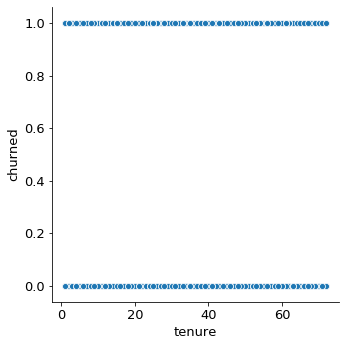

In [55]:
# Tenure vs. Rate of Churn (customers churned/total customers)
x = telco.tenure
y = telco.churned
sns.relplot(x='tenure', y='churned', data=telco)

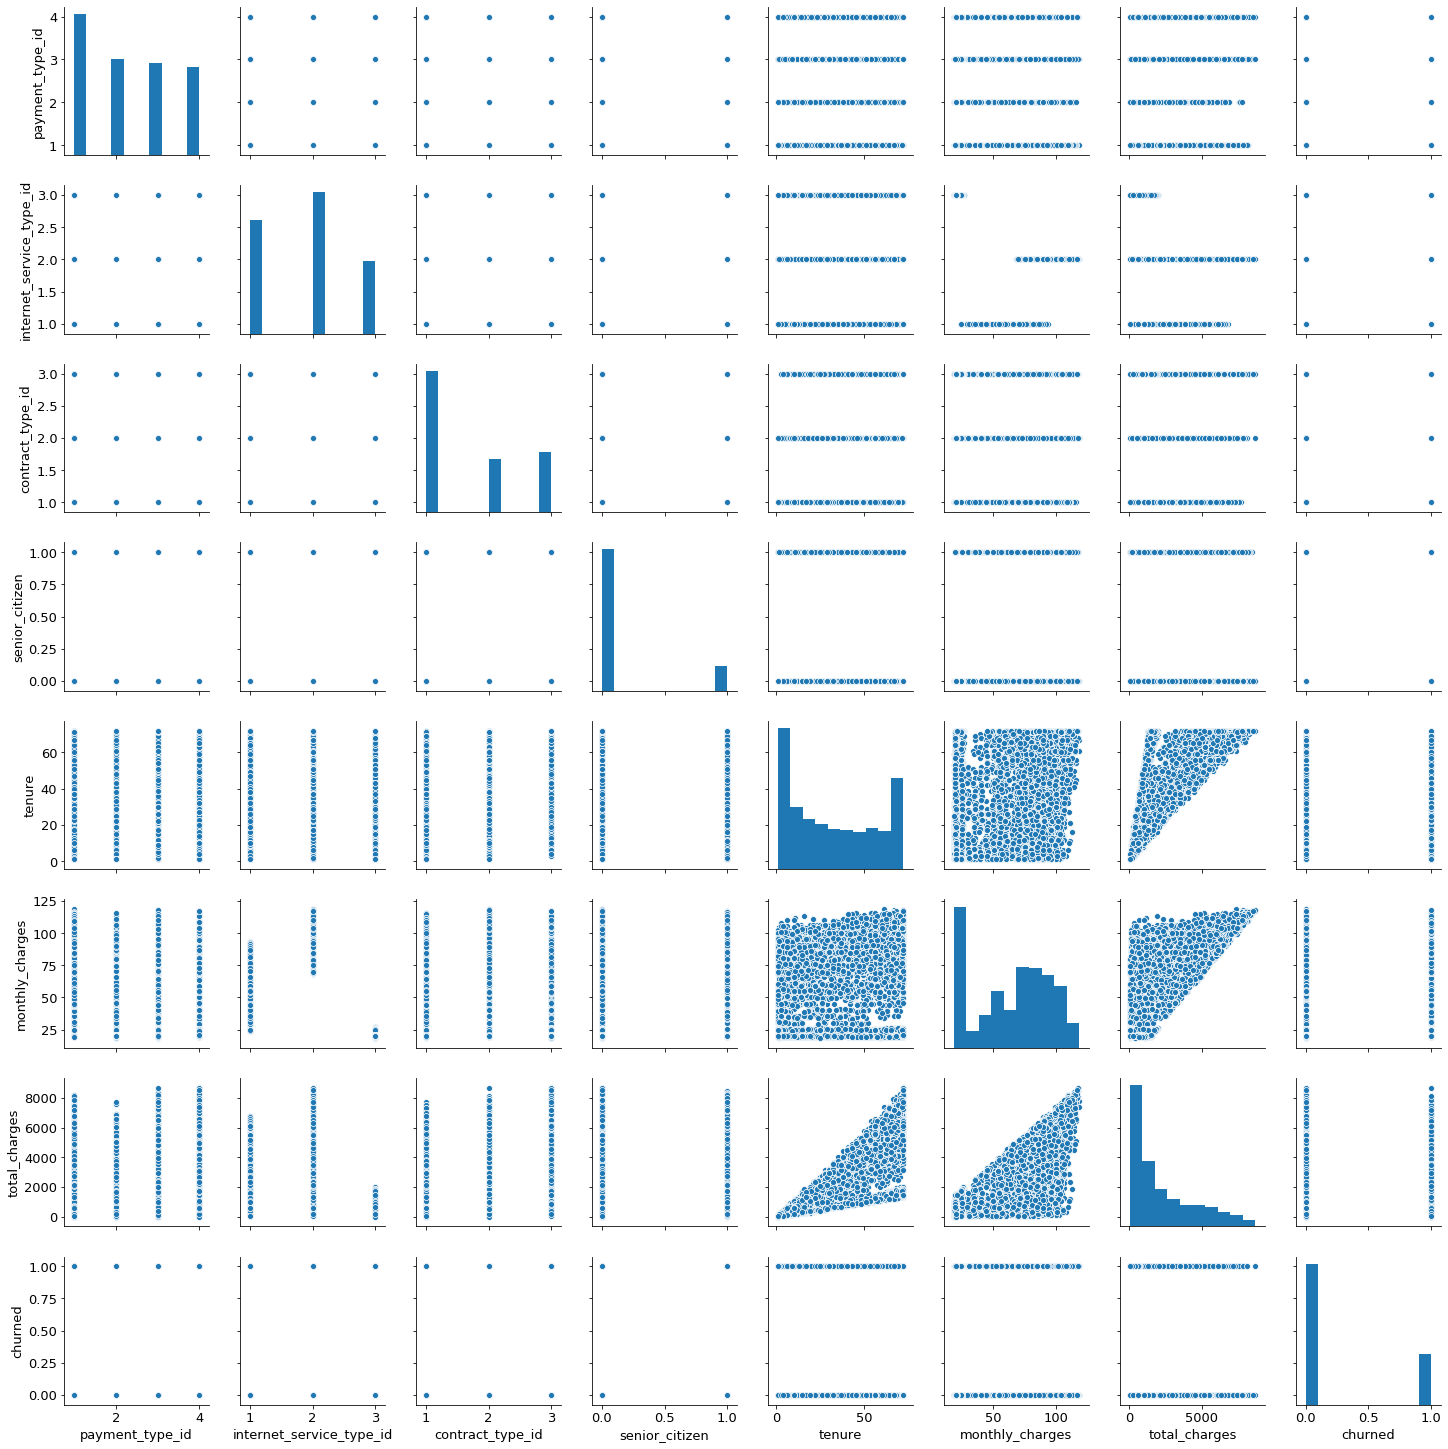

In [56]:
sns.pairplot(train)

In [ ]:
# run a t-test of churned/ not churn compare avg monthly charge
# modeling: select tenure, month charges 
# after MVP: take cat variables and use get dummies

# Testing

In [74]:
# Hypothesis Test: 2-Sample, 2-tailed T-Test
churn_sample = train[train.churned == 1].monthly_charges
no_churn_sample = train[telco.churned == 0].monthly_charges

In [75]:
# Hypotheses
#$H_{0}$: Mean of monthly charges of churned customers = Mean of monthly charges of customers who haven't churned
#$H_{a}$: Mean of monthly charges of churned customers > Mean of monthly charges of customers who haven't churned

# Alpha
alpha = .05

# Assumptions
print(churn_sample.var())
print(no_churn_sample.var())

# Compute Test Statisic and P value
t, p = stats.ttest_ind(churn_sample, no_churn_sample, equal_var = False)
print(t, p/2)

# Decide
if p/2 > alpha:
    print("We fail to reject $H_{0}$")
elif t < 0:
    print("We fail to reject $H_{0}$")
else:
    print("We reject $H_{0}$")

609.7189655008377
960.2131357344518
13.989840454395496 4.785948901718317e-43
We reject $H_{0}$


# Modeling

In [76]:
#find a baseline prediction: not churned is most frequent
train.churned.value_counts(normalize=True)

0    0.734315
1    0.265685
Name: churned, dtype: float64

In [106]:
train['baseline_prediction'] = 0

In [79]:
#baseline accuracy: Our model > 73.43% in terms of accuracy
baseline_accuracy = 1-train.churned.mean()
baseline_accuracy

0.7343154686309372

In [109]:
#baseline classification report
baseline_cr = classification_report(train.churned, train.baseline_prediction)
print(baseline_cr)

              precision    recall  f1-score   support

           0       0.73      1.00      0.85      2891
           1       0.00      0.00      0.00      1046

    accuracy                           0.73      3937
   macro avg       0.37      0.50      0.42      3937
weighted avg       0.54      0.73      0.62      3937



In [82]:
# Modeling

# Define X and y
X_train = train[['tenure', 'monthly_charges']]
y_train = train[['churned']]

X_validate = validate[['tenure', 'monthly_charges']]
y_validate = validate[['churned']]

X_test = test[['tenure', 'monthly_charges']]
y_test = test[['churned']]

#create a Logistic Regression Model
logit = LogisticRegression(random_state=123)

#fit the model to the train data
logit.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

# Evaluation

In [91]:
# Create eval_df and rename the train churned column actual.
train_eval_df = train[['churned']].rename(columns={'churned': 'actual'})

# Predict whether a passenger will survive using the X_train data; add column to eval_df
train_eval_df['predicted'] = logit.predict(X_train)

# Estimate the probability of a passenger surviving using the X_train data; add col to eval_df

train_eval_df['probability'] = logit.predict_proba(X_train)[:, 1]

train_eval_df.sample(5)

,actual,predicted,probability
6800,0,0,0.049459
5558,0,0,0.237747
6823,0,0,0.072925
73,1,0,0.396416
395,0,0,0.092596


In [95]:
#accuracy score
m1_acc = logit.score(X_train, y_train)

#classification table for model 1
print(classification_report(y_true=train_eval_df.actual, y_pred=train_eval_df.predicted))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86      2891
           1       0.65      0.44      0.53      1046

    accuracy                           0.79      3937
   macro avg       0.74      0.68      0.70      3937
weighted avg       0.78      0.79      0.78      3937



# Conclusion

In [96]:
print('Baseline Accuracy: ', baseline_accuracy)
print('Model 1(LR) Accuracy: ', m1_acc)

Baseline Accuracy:  0.7343154686309372
Model 1(LR) Accuracy:  0.7896875793751588
